In [1]:
from datetime import datetime
from pathlib import Path
from typing import List, Tuple

import sinter
from matplotlib import pyplot as plt

from main.Colour import Blue, Red, Green
from main.building_blocks.Check import Check
from main.building_blocks.detectors.Stabilizer import Stabilizer
from main.building_blocks.logical.LogicalOperator import LogicalOperator
from main.building_blocks.logical.LogicalQubit import LogicalQubit
from main.building_blocks.pauli import Pauli
from main.building_blocks.pauli.PauliLetter import PauliZ, PauliY, PauliX
from main.codes.hexagonal.ToricHexagonalCode import ToricHexagonalCode
from main.codes.hexagonal.ToricXyzSquaredCode import ToricXyzSquaredCode
from main.compiling.compilers.AncillaPerCheckCompiler import AncillaPerCheckCompiler
from main.compiling.noise.models import CircuitLevelNoise
from main.compiling.syndrome_extraction.controlled_gate_orderers.ToricXyzSquaredOrderer import ToricXyzSquaredOrderer
from main.compiling.syndrome_extraction.extractors.SyndromeExtractor import SyndromeExtractor
from main.compiling.syndrome_extraction.controlled_gate_orderers.ControlledGateOrderer import ControlledGateOrderer
from main.printing.Printer2D import Printer2D
from main.utils.utils import tuple_sum, tuple_minus, output_path

Build our $(XYZ)^2$ code by subclassing the periodic hexagonal lattice.

In [2]:
class XyzSquaredCode(ToricHexagonalCode):
    def __init__(self, distance_x: int, distance_z: int):
        assert distance_z % 2 == 0
        distance = min([distance_z, distance_x])
        assert distance > 1
        super().__init__(
            rows=distance_x, columns=distance_z, distance=distance)
        self.set_schedules([[]])

    def is_electric(self, check: Check):
        return check.anchor[0]  % 12 == 4

    def is_magnetic(self, check: Check):
        return check.anchor[0] % 12 == 10

distance_x = 3
distance_z = 4
code = XyzSquaredCode(distance_x, distance_z)

We all love a good picture:

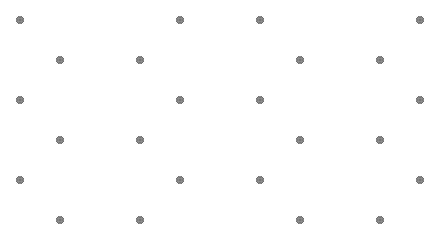

In [3]:
printer = Printer2D()
printouts = printer.print_code(code, 'XYZXYZ')
printouts[0].image

All that's needed to define a code is to specify the 'checks'. A check is just something that's measured - usually a stabilizer, but could be a gauge operator in a subsystem code, or whatever the analogue is in a dynamic code like the honeycomb code.

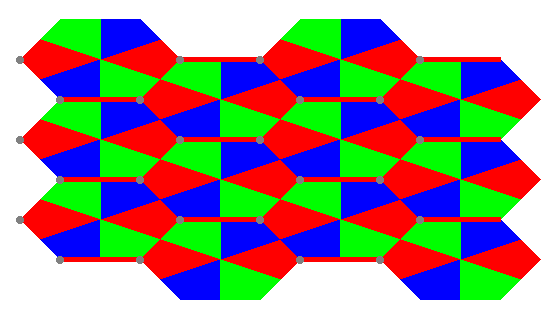

In [4]:
# Define the checks.
checks = []
xyzxyz = [PauliX, PauliY, PauliZ, PauliX, PauliY, PauliZ]

for anchor in code.plaquette_anchors:
    # On each hexagon, create one weight-6 XYZXYZ check.
    corners = code.get_neighbour_coords(anchor)
    data_qubits = [
        code.data_qubits[code.wrap_coords(corner)]
        for corner in corners]
    offsets = [tuple_minus(corner, anchor) for corner in corners]
    paulis = {
        offset: Pauli(qubit, letter)
        for offset, qubit, letter in zip(offsets, data_qubits, xyzxyz)}
    checks.append(Check(paulis, anchor))

    # Also, create one of the weight-2 XX checks connected to this face.
    u = corners[0]
    v = code.get_neighbour_coords(u)[0]
    X_u = Pauli(code.data_qubits[code.wrap_coords(u)], PauliX)
    X_v = Pauli(code.data_qubits[code.wrap_coords(v)], PauliX)
    midpoint = code.wrap_coords((u[0] + 2, u[1]))
    checks.append(Check({(-2, 0): X_u, (2, 0): X_v}, midpoint))

code.set_schedules([checks])

printouts = printer.print_code(code, 'XYZXYZ_checks')
printouts[0].image

Pretty! But actually not a helpful colouring. Let's recolour things along electric/magnetic lines, and use a third colour for the little $XX$ checks.

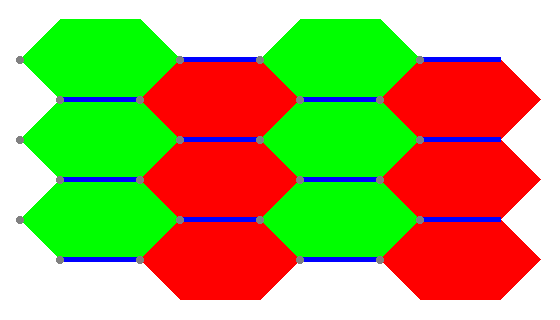

In [5]:
for check in code.checks:
    if check.weight == 2:
        check.colour = Blue
    elif code.is_electric(check):
        check.colour = Green
    else:
        check.colour = Red

printouts = printer.print_code(code, 'XYZXYZ_recoloured')
printouts[0].image

Better. Now let's define a logical $\bar{X}$ operator/observable (pick your favourite term).

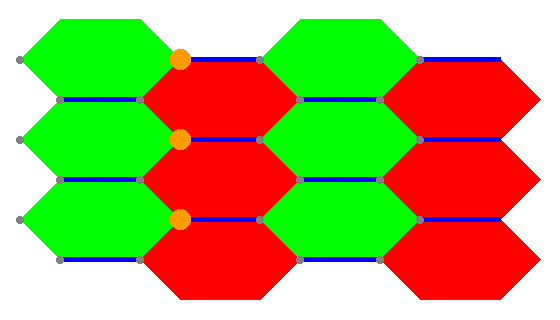

In [6]:
support = [(8, 4 * i + 2) for i in range(distance_x)]
paulis = [Pauli(code.data_qubits[coords], PauliX) for coords in support]
logical_x = LogicalOperator(paulis)
# Would normally give the logical Z too, but we're being lazy.
logical_qubit = LogicalQubit(logical_x, None)
code.logical_qubits = [logical_qubit]

printouts = printer.print_code(code, 'XYZXYZ_logical')
printouts[0].image

We've now fully defined the code! Now to think about compiling it to a circuit. First we need to think about what states to initialise the data qubits into, and what to measure at the end. One way to do this is to specify which operators we'd like to specify at the start and end.

In [7]:
initial_stabilizers = []
final_stabilizers = []
for x in range(4, 12 * distance_z // 2, 12):
    for y in range(0, 4 * distance_x, 4):
        # Take each electric XX check...
        xx_check = next(
            check for check in code.checks
            if check.anchor == (x, y))
        # ... and the electric XYZXYZ check above it...
        xyzxyz_check = next(
            check for check in code.checks if
            check.anchor == (x, y + 2))
        # ... and combine them into a stabilizer. One for the start...
        timed_checks = [(0, xx_check), (0, xyzxyz_check)]
        initial_stabilizers.append(Stabilizer(timed_checks, 0, (x, y + 2, 0)))
        # ... and one for the end.
        timed_checks = [(-1, xx_check), (-1, xyzxyz_check)]
        final_stabilizers.append(Stabilizer(timed_checks, 0, (x, y + 2, 0)))

# Now do the magnetic XX stabilizers
for x in range(10, 12 * distance_z // 2, 12):
    for y in range(2, 4 * distance_x, 4):
        xx_check = next(
            check for check in code.checks
            if check.anchor == (x, y))
        initial_stabilizers.append(Stabilizer([(0, xx_check)], 0, (x, y, 0)))
        final_stabilizers.append(Stabilizer([(-1, xx_check)], 0, (x, y, 0)))

To compile this, we must specify how to extract the syndromes. We'll use a single ancilla qubit per ancilla, and specify a CNOT ordering between the ancilla and the data qubits.

In [11]:
class XyzSquaredOrderer(ControlledGateOrderer):
    def __init__(self):
        super().__init__()
        self.xx_order = {
            (2, 0): 1,
            (-2, 0): 4}
        self.xyzxyz_order = {
            (4, 0): 1,
            (2, 2): 3,
            (-2, 2): 5,
            (-4, 0): 4,
            (-2, -2): 2,
            (2, -2): 0}

    def order(self, check: Check) -> List[Pauli | None]:
        paulis = [None for _ in range(6)]
        ordering = self.xx_order if check.weight == 2 else self.xyzxyz_order
        for offset, pauli in check.paulis.items():
            order = ordering[offset]
            paulis[order] = pauli
        return paulis

Now we can combine this with a noise model to get a compiler. We'll choose circuit-level noise.

In [9]:
syndrome_extractor = SyndromeExtractor(XyzSquaredOrderer())
noise_model = CircuitLevelNoise(0.01, 0.02, 0.03, 0.04, 0.05)
compiler = AncillaPerCheckCompiler(noise_model, syndrome_extractor)

 Done! Now we can use this compiler to run a memory experiment simulation. First, compile to a Stim circuit.

In [1]:
circuit = compiler.compile_code(
    code, code.distance,
    initial_stabilizers=initial_stabilizers,
    final_stabilizers=final_stabilizers,
    logical_observables=[code.logical_qubits[0].x])
print(circuit)

NameError: name 'compiler' is not defined

To decode our circuit, need to write a decoder. Didn't have time to do this before this demo! Fortunately, it turns out that for small $(XYZ)^2$ codes, Stim can figure out a way to just use matching. So we can at least show the breakeven point for a specific small code under this decoder.

In [ ]:
noise_parameters = [0.0001 * i + 0.0001 for i in range(10)]

def xyz_squared_tasks():
    tasks = []
    syndrome_extractor = SyndromeExtractor(ToricXyzSquaredOrderer())
    distances = [(3, 4, 3)]
    for noise_parameter in noise_parameters:
        print(f'Circuit-level noise parameter: {noise_parameter}')
        for distance in distances:
            print(f'Distance: {distance}')
            tasks.append(xyz_squared_task(
                distance, noise_parameter, syndrome_extractor))
    return tasks


def xyz_squared_task(
        distance: Tuple[int, int, int], noise_model_parameter: float,
        syndrome_extractor: SyndromeExtractor):
    p = noise_model_parameter
    noise_model = CircuitLevelNoise(p, p, p, p, p)
    compiler = AncillaPerCheckCompiler(noise_model, syndrome_extractor)

    distance_x, distance_z, layers = distance
    code = ToricXyzSquaredCode(distance_x, distance_z)
    initial_stabilizers, final_stabilizers = code.get_plus_plus_stabilizers()
    circuit = compiler.compile_code(
        code,
        layers,
        initial_stabilizers=initial_stabilizers,
        final_stabilizers=final_stabilizers,
        logical_observables=[code.logical_qubits[0].x])
    return sinter.Task(
        circuit=circuit,
        json_metadata={
            'distance': distance,
            'p': noise_model_parameter})

Now wait while Sinter works its magic...

Circuit-level noise parameter: 0.0001
Distance: (3, 4, 3)
|████████████████████████████████████████✗︎ (!) 99/96 [103%] in 0.6s (167.50/s)                                          0s) 
Circuit-level noise parameter: 0.0002
Distance: (3, 4, 3)
|████████████████████████████████████████✗︎ (!) 99/96 [103%] in 0.6s (179.79/s)                                          
Circuit-level noise parameter: 0.00030000000000000003
Distance: (3, 4, 3)
|████████████████████████████████████████✗︎ (!) 99/96 [103%] in 0.6s (171.24/s)                                          
Circuit-level noise parameter: 0.0004
Distance: (3, 4, 3)
|████████████████████████████████████████✗︎ (!) 99/96 [103%] in 0.6s (163.85/s)                                          
Circuit-level noise parameter: 0.0005
Distance: (3, 4, 3)
|████████████████████████████████████████✗︎ (!) 99/96 [103%] in 0.6s (172.15/s)                                           0s) 
Circuit-level noise parameter: 0.0006000000000000001
Distance: (3, 4, 3)
|█

Starting workers...
10 cases left
    case: processes=5  ~core_mins_left=2       shots_left=497800   errors_left=100     {'distance': (3, 4, 3), 'p': 0.0001}
    case: processes=2  ~core_mins_left=1       shots_left=498800   errors_left=99      {'distance': (3, 4, 3), 'p': 0.0002}
    case: processes=1  ~core_mins_left=7       shots_left=499500   errors_left=100     {'distance': (3, 4, 3), 'p': 0.00030000000000000003}
    case: processes=0  ~core_mins_left=10      shots_left=499700   errors_left=100     {'distance': (3, 4, 3), 'p': 0.0004}
    case: processes=0  ~core_mins_left=8       shots_left=499700   errors_left=100     {'distance': (3, 4, 3), 'p': 0.0005}
    case: processes=0  ~core_mins_left=29      shots_left=499900   errors_left=100     {'distance': (3, 4, 3), 'p': 0.0006000000000000001}
    case: processes=0  ~core_mins_left=1       shots_left=499900   errors_left=99      {'distance': (3, 4, 3), 'p': 0.0007000000000000001}
    case: processes=0  ~core_mins_left=1       shots

10 cases left
    case: processes=1  ~core_mins_left=1       shots_left=132800   errors_left=83      {'distance': (3, 4, 3), 'p': 0.0001}
    case: processes=2  ~core_mins_left=1       shots_left=231200   errors_left=63      {'distance': (3, 4, 3), 'p': 0.0002}
    case: processes=4  ~core_mins_left=1       shots_left=459500   errors_left=83      {'distance': (3, 4, 3), 'p': 0.00030000000000000003}
    case: processes=1  ~core_mins_left=2       shots_left=497300   errors_left=100     {'distance': (3, 4, 3), 'p': 0.0004}
    case: processes=0  ~core_mins_left=8       shots_left=499700   errors_left=100     {'distance': (3, 4, 3), 'p': 0.0005}
    case: processes=0  ~core_mins_left=29      shots_left=499900   errors_left=100     {'distance': (3, 4, 3), 'p': 0.0006000000000000001}
    case: processes=0  ~core_mins_left=1       shots_left=499900   errors_left=99      {'distance': (3, 4, 3), 'p': 0.0007000000000000001}
    case: processes=0  ~core_mins_left=1       shots_left=499900   error

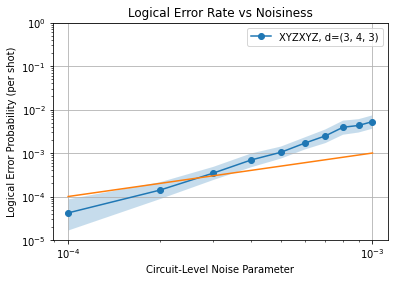

Done collecting


In [ ]:
# Collect the samples (takes a few minutes).
tasks = xyz_squared_tasks()
samples = sinter.collect(
    tasks=tasks,
    hint_num_tasks=len(tasks),
    num_workers=8,
    max_shots=500000,
    max_errors=100,
    decoders=['pymatching'],
    print_progress=True
)

filename = 'XyzSquared'
now = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f'{output_path()}/{filename}_{now}'
Path(Path(filename).parent).mkdir(parents=True, exist_ok=True)

# Render a matplotlib plot of the data.
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=samples,
    group_func=lambda stat: f"XYZXYZ, d={stat.json_metadata['distance']}",
    x_func=lambda stat: stat.json_metadata['p'],
)
ax.plot(noise_parameters, noise_parameters)
ax.loglog()
ax.set_ylim(1e-5, 1)
ax.grid()
ax.set_title('Logical Error Rate vs Noisiness')
ax.set_ylabel('Logical Error Probability (per shot)')
ax.set_xlabel('Circuit-Level Noise Parameter')
ax.legend()

# Save to file and also open in a window.
fig.savefig(f'{filename}.png')
plt.show()